# Autoencoder para reducción de ruido

El modelo es tomado de [GuitarsAI](https://github.com/GuitarsAI) https://www.youtube.com/watch?v=gVFCX-olr-M

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa
from pydub import AudioSegment

In [2]:
if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cuda


In [3]:
os.chdir("../Audios")
wd=os.getcwd()
wd_norm=os.listdir('Normal')
wd_sarc=os.listdir('Sarcasmo')

## Pasar de mp3 a wav

Aqui hay un problema, no esta leyendo el audio 35, ni 36, no sé si de ahí en adelante tampoco

In [5]:
for audio in wd_norm:
    # files                                                                         
    src = "Normal/"+audio
    dst = "Normal_wav/"+audio[:-3]+"wav"
    
    # convert wav to mp3    Audios/Normal/Audio_1.mp3                                                        
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/thejarmanitor/miniconda3/envs/torch-gpu --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
[mp3 @ 0x55ef1d4c2c40] Invalid frame size (704): Could not seek to 16656.
Normal/Audio_44.mp3: Invalid argument


In [6]:
from IPython.display import Audio
display(Audio('Normal/Audio_35.mp3'))

Aquí tambien hay problemas, el audio 100 no lo está leyendo

In [7]:
for audio in wd_sarc:
    # files                                                                         
    src = "Sarcasmo/"+audio
    dst = "Sarcasmo_wav/"+audio[:-3]+"wav"
    
    # convert wav to mp3    Audios/Normal/Audio_1.mp3                                                        
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

In [8]:
display(Audio('Sarcasmo/Audio_100.mp3'))

Con uno de los audios que si se pasaron a .wav mire algo del procesamiento de audios tomado de [Beginner's Guide to Audio Data](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data). Los siguientes gráficos son del audio crudo (1D array) 

In [9]:
display(Audio('Normal_wav/Audio_1.wav'))

In [10]:
# scipy
from scipy.io import wavfile
rate, data = wavfile.read("Normal_wav/Audio_1.wav")
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

In [11]:
#Gráfico de los frames(marcos) del audio
plt.plot(data, '-', );

In [12]:
#Zoom en los primeros 1000 frames
plt.figure(figsize=(16, 4))
plt.plot(data[:1000], '.'); plt.plot(data[:1000], '-');

## Con audios en MP3

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa
from pydub import AudioSegment

In [2]:
if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cuda


In [3]:
os.chdir("../Audios")
wd=os.getcwd()
wd_norm=os.listdir('Normal')
wd_sarc=os.listdir('Sarcasmo')

In [4]:
y, sr = librosa.load("Normal/Audio_1.mp3")
librosa.feature.melspectrogram(y=y, sr=sr)

/home/thejarmanitor/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


array([[1.4124211e-04, 6.4624433e-04, 2.0889274e-03, ..., 2.6005888e-03,
        8.9461613e-04, 6.6318811e-04],
       [2.1077051e-04, 8.7722071e-04, 2.4391920e-03, ..., 1.4399672e-03,
        7.1109447e-04, 1.7961246e-03],
       [2.7493734e-04, 6.7092339e-04, 9.4860344e-04, ..., 2.6280112e-03,
        1.3145995e-03, 1.8213964e-03],
       ...,
       [1.7611904e-09, 9.3290140e-07, 8.9800005e-06, ..., 2.6329703e-09,
        2.8371495e-08, 8.7693940e-07],
       [8.1298424e-10, 3.4993198e-07, 2.6490557e-06, ..., 2.6378217e-09,
        2.4373133e-08, 7.6044631e-07],
       [4.5773423e-11, 2.9024948e-08, 2.8090284e-07, ..., 1.6430658e-10,
        1.5182458e-08, 5.0437274e-07]], dtype=float32)

In [5]:
# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

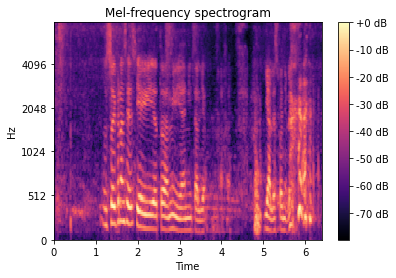

In [6]:
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [7]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [8]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek

In [9]:
batch=1
audio, samplerate = librosa.load("Normal/Audio_1.mp3", mono=False, sr=None, offset=6)
audio[0,:]/=np.abs(audio[0,:]).max()
audio[1,:]/=np.abs(audio[1,:]).max()
X_train=signal2pytorch(audio[0,:]).to(device) #Convert to pytorch format, batch is first dimension    
X_test=signal2pytorch(audio[1,:]).to(device) #Convert to pytorch format, batch is first dimension

/home/thejarmanitor/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [18]:
print("Generate Model:")
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("Def. loss function:")
loss_fn = nn.MSELoss()  #MSE
#loss_fn = nn.L1Loss()
    
Ypred=model(X_train)
   
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X_train[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X_train.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())
print(Y.device)

Generate Model:
Total number of parameters: 131105
Def. loss function:
outputlen= 16386
Input X.shape= torch.Size([1, 1, 16488])
Target Y.shape= torch.Size([1, 1, 16386])
Target Y= tensor([[[-0.0267,  0.0019, -0.0475,  ..., -0.0372, -0.0353, -0.0291]]],
       device='cuda:0')
Y.type()= torch.cuda.FloatTensor
cuda:0


In [11]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
""";
    
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
Ypred=model(X_train)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False
    
if randdir==True:
#optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X_train, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(4000):
        #distortions: shift and noise:
        #"""
        Xlast=X_train[:,:,-1].clone() 
        X_train[:,:,1:]=X_train[:,:,:-1].clone() #round Robbin, shift 1 right
        X_train[:,:,0]=Xlast.clone()
        Ylast=Y[:,:,-1].clone() 
        Y[:,:,1:]=Y[:,:,:-1].clone() #round Robbin, shift 1 right
        Y[:,:,0]=Ylast.clone()
        #"""
        Ypred=model(X_train+torch.randn(X_train.size()).to(device)*0.05)
        #print("Ypred.shape=", Ypred.shape)
        #loss wants batch in the beginning! (Batch, Classes,...)
        #Ypredp=Ypred.permute(1,2,0)
        #Yp=Y.permute(1,0)
        #print("Ypredp.shape=", Ypredp.shape, "Yp.shape=", Yp.shape )
        loss=loss_fn(Ypred, Y)
        if epoch%10==0:
            print(epoch, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Ypred= tensor([[[-0.0116,  0.0007,  0.0051,  ..., -0.0090, -0.0083, -0.0068]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
0 0.024865377694368362
10 0.02382166124880314
20 0.023105282336473465
30 0.022664599120616913
40 0.020201191306114197
50 0.016309842467308044
60 0.01490771397948265
70 0.015443719923496246
80 0.01433559413999319
90 0.011386544443666935
100 0.010120870545506477
110 0.011070473119616508
120 0.010708659887313843
130 0.00979761965572834
140 0.008880071341991425
150 0.009537850506603718
160 0.009345006197690964
170 0.009162827394902706
180 0.008444137871265411
190 0.008765550330281258
200 0.00871463306248188
210 0.008797173388302326
220 0.008393696509301662
230 0.008259210735559464
240 0.008335716091096401
250 0.008626594208180904
260 0.008610669523477554
270 0.008150572888553143
280 0.008384029380977154
290 0.008429246954619884
300 0.008619679138064384
310 0.008136049844324589
320 0.008185132406651974
330 0.008138966746628284
340 0.008434733375906944
350 0.008

ww= OrderedDict([('conv1.weight', tensor([[[ 0.0344,  0.0373,  0.0207,  ...,  0.0018, -0.0070, -0.0256]],

        [[-0.0022, -0.0092, -0.0040,  ..., -0.0260, -0.0189, -0.0154]],

        [[-0.0372, -0.0280, -0.0412,  ...,  0.0320,  0.0313,  0.0178]],

        ...,

        [[ 0.0191,  0.0165,  0.0403,  ...,  0.0220,  0.0090,  0.0428]],

        [[ 0.0191,  0.0002,  0.0075,  ..., -0.0314, -0.0295, -0.0104]],

        [[-0.0486, -0.0409, -0.0304,  ..., -0.0082,  0.0092,  0.0041]]])), ('conv1.bias', tensor([ 0.0017, -0.0007,  0.0020,  0.0014,  0.0049, -0.0026, -0.0040, -0.0019,
         0.0030, -0.0039, -0.0011, -0.0034, -0.0038,  0.0066, -0.0040, -0.0060,
         0.0030,  0.0075,  0.0046,  0.0065, -0.0007,  0.0005,  0.0011, -0.0028,
         0.0005, -0.0002,  0.0089,  0.0078, -0.0037,  0.0040,  0.0017,  0.0068])), ('synconv1.weight', tensor([[[ 0.0105,  0.0090,  0.0255,  ...,  0.0151,  0.0197,  0.0268]],

        [[-0.0310, -0.0126, -0.0239,  ..., -0.0200, -0.0122, -0.0066]],

        

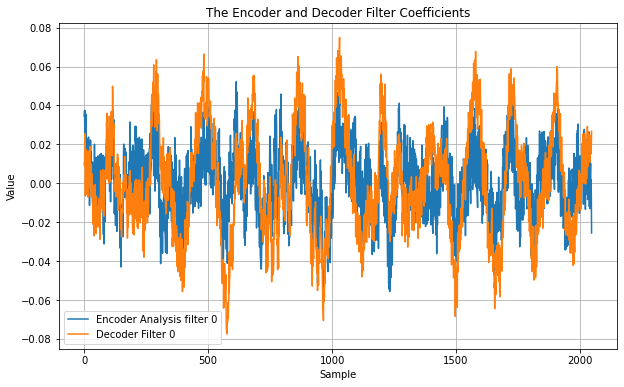

In [12]:
"""
torch.save({#'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, "audio_autoenc.torch")
"""
    
ww = model.cpu().state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

In [19]:
#Test on training set:
Xnoise=(X_train+torch.randn(X_train.size()).to(device)*0.05)
#Xnoise=torch.cat((torch.zeros(1,1,100), Xnoise),dim=-1)
predictions=model(Xnoise.cpu()) # Make Predictions based on the obtained weights, on training set
predictions=predictions.detach()
predictions=np.array(predictions)
Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(Y)
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()

Xnoise=Xnoise.detach()
Xnoise=np.array(Xnoise)
xnoise=Xnoise[:,0,:]
#xnoise=np.transpose(xnoise)
#xnoise=np.clip(xnoise, -1.0,1.0)
    
xrek=predictions[:,0,:]  #remove unnecessary dimension for playback
#xrek=np.transpose(xrek)
#xrek=np.clip(xrek, -1.0,1.0)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking arugment for argument weight in method wrapper_thnn_conv2d_forward)

In [21]:
torch.randn(X_train.size()).device

device(type='cpu')

In [32]:
import IPython.display as ipd
display(ipd.Audio(xnoise, rate=samplerate));

In [33]:
import IPython.display as ipd
display(ipd.Audio(xrek, rate=samplerate));

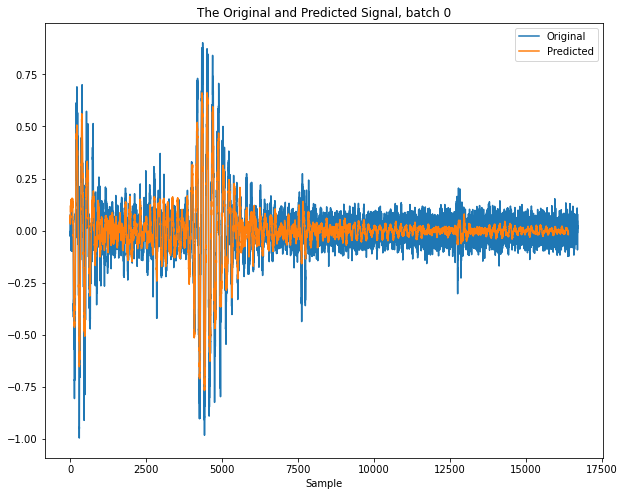

In [34]:
#Test on Verification set:
X_test_shifted_100 = nn.ConstantPad1d(100, 0)(X_test)
x=X_test_shifted_100+torch.from_numpy((np.random.normal(scale=0.04, size=X_test_shifted_100.shape))).float()
predictions=model(x).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)

plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(np.array(x[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()
xrek=predictions[:,0,:]

In [35]:
display(ipd.Audio(x[:,0,:], rate=samplerate))

In [36]:
display(ipd.Audio(xrek, rate=samplerate))